# 时间序列建模

本篇文章将利用 TensorFlow 2.0 建立时间序列RNN模型，对国内的新冠肺炎疫情结束时间进行预测。

In [1]:
# 下载数据
!wget https://raw.githubusercontent.com/lyhue1991/eat_tensorflow2_in_30_days/master/data/covid-19.csv

--2020-10-06 07:15:23--  https://raw.githubusercontent.com/lyhue1991/eat_tensorflow2_in_30_days/master/data/covid-19.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1563 (1.5K) [text/plain]
Saving to: ‘covid-19.csv’

covid-19.csv        100%[===================>]   1.53K  --.-KB/s    in 0s      

2020-10-06 07:15:23 (30.1 MB/s) - ‘covid-19.csv’ saved [1563/1563]



In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf 
from tensorflow.keras import models,layers,losses,metrics,callbacks 

(array([-10.,   0.,  10.,  20.,  30.,  40.,  50.]),
 <a list of 7 Text major ticklabel objects>)

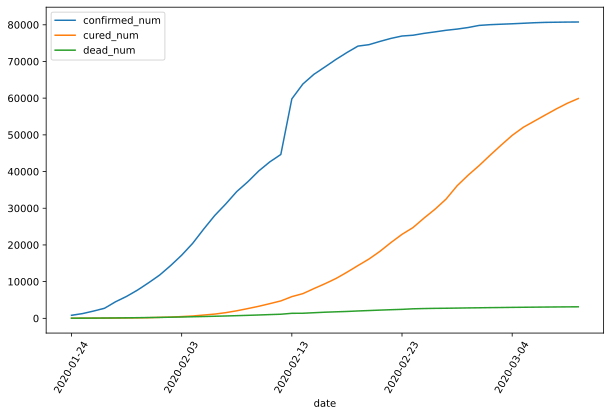

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

df = pd.read_csv("./covid-19.csv",sep = "\t")
df.plot(x = "date",y = ["confirmed_num","cured_num","dead_num"],figsize=(10,6))
plt.xticks(rotation=60)

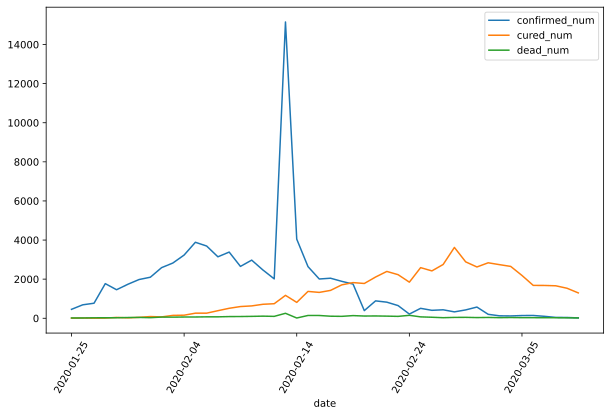

In [5]:
dfdata = df.set_index("date")
dfdiff = dfdata.diff(periods=1).dropna()
dfdiff = dfdiff.reset_index("date")

dfdiff.plot(x = "date",y = ["confirmed_num","cured_num","dead_num"],figsize=(10,6))
plt.xticks(rotation=60)
dfdiff = dfdiff.drop("date",axis = 1).astype("float32")

In [6]:
# 用某日前 8 天窗口数据作为输入预测该日数据
WINDOW_SIZE = 8

def batch_dataset(dataset):
    dataset_batched = dataset.batch(WINDOW_SIZE,drop_remainder=True)
    return dataset_batched

ds_data = tf.data.Dataset.from_tensor_slices(tf.constant(dfdiff.values,dtype = tf.float32)) \
   .window(WINDOW_SIZE,shift=1).flat_map(batch_dataset)

ds_label = tf.data.Dataset.from_tensor_slices(
    tf.constant(dfdiff.values[WINDOW_SIZE:],dtype = tf.float32))

# 数据较小，可以将全部训练数据放入到一个 Batch 中，提升性能
ds_train = tf.data.Dataset.zip((ds_data,ds_label)).batch(38).cache()

# 定义模型

使用Keras接口有以下3种方式构建模型：

- 使用Sequential按层顺序构建模型
- 使用函数式API构建任意结构模型
- 继承Model基类构建自定义模型。

此处选择使用函数式API构建任意结构模型。



In [7]:
# 考虑到新增确诊，新增治愈，新增死亡人数数据不可能小于0，设计如下结构
class Block(layers.Layer):
    def __init__(self, **kwargs):
        super(Block, self).__init__(**kwargs)
    
    def call(self, x_input,x):
        x_out = tf.maximum((1+x)*x_input[:,-1,:],0.0)
        return x_out
    
    def get_config(self):  
        config = super(Block, self).get_config()
        return config


In [8]:
tf.keras.backend.clear_session()
x_input = layers.Input(shape = (None,3),dtype = tf.float32)
x = layers.LSTM(3,return_sequences = True,input_shape=(None,3))(x_input)
x = layers.LSTM(3,return_sequences = True,input_shape=(None,3))(x)
x = layers.LSTM(3,return_sequences = True,input_shape=(None,3))(x)
x = layers.LSTM(3,input_shape=(None,3))(x)
x = layers.Dense(3)(x)

# 考虑到新增确诊，新增治愈，新增死亡人数数据不可能小于0，设计如下结构
#x = tf.maximum((1+x)*x_input[:,-1,:],0.0)
x = Block()(x_input,x)
model = models.Model(inputs = [x_input],outputs = [x])
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 3)]    0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, None, 3)      84          input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, None, 3)      84          lstm[0][0]                       
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, None, 3)      84          lstm_1[0][0]                     
_______________________________________________________________________________________

# 训练模型

In [ ]:
#自定义损失函数，考虑平方差和预测目标的比值
class MSPE(losses.Loss):
    def call(self,y_true,y_pred):
        err_percent = (y_true - y_pred)**2/(tf.maximum(y_true**2,1e-7))
        mean_err_percent = tf.reduce_mean(err_percent)
        return mean_err_percent
    
    def get_config(self):
        config = super(MSPE, self).get_config()
        return config
        
import os
import datetime

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=optimizer,loss=MSPE(name = "MSPE"))

stamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
logdir = os.path.join('data', 'autograph', stamp)

## 在 Python3 下建议使用 pathlib 修正各操作系统的路径
# from pathlib import Path
# stamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# logdir = str(Path('./data/autograph/' + stamp))

tb_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
#如果loss在100个epoch后没有提升，学习率减半。
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor="loss",factor = 0.5, patience = 100)
#当loss在200个epoch后没有提升，则提前终止训练。
stop_callback = tf.keras.callbacks.EarlyStopping(monitor = "loss", patience= 200)
callbacks_list = [tb_callback,lr_callback,stop_callback]

history = model.fit(ds_train,epochs=500,callbacks = callbacks_list)

# 评估模型

评估模型一般要设置验证集或者测试集，由于此例数据较少，我们仅仅可视化损失函数在训练集上的迭代情况。



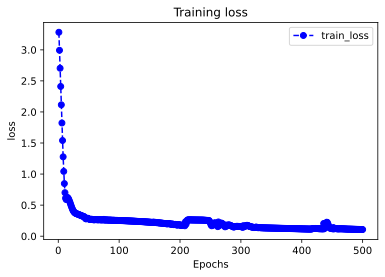

In [10]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

def plot_metric(history, metric):
    train_metrics = history.history[metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.title('Training '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric])
    plt.show()

plot_metric(history,"loss")


# 模型使用

此处我们使用模型预测疫情结束时间，即 新增确诊病例为0 的时间。



In [11]:
# 使用 dfresult 记录现有数据以及此后预测的疫情数据
dfresult = dfdiff[["confirmed_num","cured_num","dead_num"]].copy()
dfresult.tail()

# 预测此后100天的新增走势,将其结果添加到dfresult中
for i in range(100):
    arr_predict = model.predict(tf.constant(tf.expand_dims(dfresult.values[-38:,:],axis = 0)))

    dfpredict = pd.DataFrame(tf.cast(tf.floor(arr_predict),tf.float32).numpy(),
                columns = dfresult.columns)
    dfresult = dfresult.append(dfpredict,ignore_index=True)

In [12]:
dfresult.query("confirmed_num==0").head()

# 第55天开始新增确诊降为0，第45天对应3月10日，也就是10天后，即预计3月20日新增确诊降为0
# 注：该预测偏乐观

,confirmed_num,cured_num,dead_num
49,0.0,833.0,1.0
50,0.0,740.0,0.0
51,0.0,654.0,0.0
52,0.0,577.0,0.0
53,0.0,515.0,0.0


# 保存模型

推荐使用 TensorFlow 原生方式保存模型。



In [14]:
model.save('./tf_model_savedmodel', save_format="tf")
print('export saved model.')

model_loaded = tf.keras.models.load_model('./tf_model_savedmodel',compile=False)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model_loaded.compile(optimizer=optimizer,loss=MSPE(name = "MSPE"))
model_loaded.predict(ds_train)

INFO:tensorflow:Assets written to: ./tf_model_savedmodel/assets
export saved model.


array([[1861.9282  ,   97.88871 ,   34.38245 ],
       [2296.5852  ,   76.75365 ,   69.91098 ],
       [2505.9302  ,  163.51863 ,   65.32665 ],
       [2867.8486  ,  174.64235 ,   73.34923 ],
       [3447.0955  ,  289.21664 ,   74.49531 ],
       [3276.7808  ,  290.329   ,   83.66396 ],
       [2788.0137  ,  430.48785 ,   83.66396 ],
       [3002.681   ,  567.3096  ,   98.56303 ],
       [2352.4697  ,  666.3106  ,  102.00127 ],
       [2637.2144  ,  703.0189  ,  111.16992 ],
       [2026.6033  ,  771.8911  ,  111.50191 ],
       [1296.1781  ,  745.72095 ,   69.19297 ],
       [4415.5317  ,  994.5283  ,    0.      ],
       [2239.4614  ,  779.0968  ,    0.      ],
       [2508.8147  , 1549.2253  ,   91.15738 ],
       [1984.9015  , 1517.395   ,  134.54181 ],
       [2024.7202  , 1636.7169  ,  119.7118  ],
       [1860.368   , 1961.6815  ,  124.19464 ],
       [ 731.8928  , 1649.6821  ,   90.49049 ],
       [ 299.8297  , 1891.1019  ,  133.80064 ],
       [ 486.15726 , 2035.4076  ,  101.2